<a href="https://colab.research.google.com/github/vardhan307/Forecasting-Cryptocurrency-Prices-Using-Time-Series-and-News-Sentiment-Analysis-/blob/main/Finalprojectvardhanvvs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima
!pip install tensorflow
!pip install pandas numpy matplotlib seaborn plotly scikit-learn
!pip install --upgrade scikit-learn
# Install Kaggle library
!pip install kaggle

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, Dropout
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import VAR
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from google.colab import files
import os
import nltk
import re
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score



The data file is large enough and does not allow us to loaad data manually or from my drive.So i

In [ ]:
#reading bitcoin data
btc = pd.read_csv('/content/btc_10yrs.csv')

In [ ]:
btc.info()
btc.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3701 entries, 0 to 3700
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Price      3701 non-null   object
 1   Adj Close  3700 non-null   object
 2   Close      3700 non-null   object
 3   High       3700 non-null   object
 4   Low        3700 non-null   object
 5   Open       3700 non-null   object
 6   Volume     3700 non-null   object
dtypes: object(7)
memory usage: 202.5+ KB


,Price,Adj Close,Close,High,Low,Open,Volume
count,3701,3700,3700,3700,3700,3700,3700
unique,3701,3697,3697,3697,3698,3696,3700
top,Ticker,1179.969970703125,1179.969970703125,267.00299072265625,429.0769958496094,17760.30078125,BTC-USD
freq,1,2,2,2,2,2,1


In [ ]:
btc.head(5)

,Price,Adj Close,Close,High,Low,Open,Volume
0,Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
1,Date,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-09-17 00:00:00+00:00,457.3340148925781,457.3340148925781,468.17401123046875,452.4219970703125,465.864013671875,21056800
3,2014-09-18 00:00:00+00:00,424.44000244140625,424.44000244140625,456.8599853515625,413.10400390625,456.8599853515625,34483200
4,2014-09-19 00:00:00+00:00,394.7959899902344,394.7959899902344,427.8349914550781,384.5320129394531,424.1029968261719,37919700


In [ ]:
btc.isna()
btc.dropna()
btc = btc.iloc[2:]
btc.reset_index(drop = True,inplace = True)
btc


,Price,Adj Close,Close,High,Low,Open,Volume
0,2014-09-17 00:00:00+00:00,457.3340148925781,457.3340148925781,468.17401123046875,452.4219970703125,465.864013671875,21056800
1,2014-09-18 00:00:00+00:00,424.44000244140625,424.44000244140625,456.8599853515625,413.10400390625,456.8599853515625,34483200
2,2014-09-19 00:00:00+00:00,394.7959899902344,394.7959899902344,427.8349914550781,384.5320129394531,424.1029968261719,37919700
3,2014-09-20 00:00:00+00:00,408.90399169921875,408.90399169921875,423.2959899902344,389.88299560546875,394.6730041503906,36863600
4,2014-09-21 00:00:00+00:00,398.8210144042969,398.8210144042969,412.4259948730469,393.1809997558594,408.0849914550781,26580100
...,...,...,...,...,...,...,...
3694,2024-10-28 00:00:00+00:00,69907.7578125,69907.7578125,70212.265625,67535.1328125,67922.671875,38799856657
3695,2024-10-29 00:00:00+00:00,72720.4921875,72720.4921875,73577.2109375,69729.9140625,69910.046875,58541874402
3696,2024-10-30 00:00:00+00:00,72339.5390625,72339.5390625,72905.296875,71411.734375,72715.3671875,40646637831
3697,2024-10-31 00:00:00+00:00,70215.1875,70215.1875,72662.3125,69590.5,72335.046875,40627912076


In [ ]:
#renaming the column name from price to date
btc.rename(columns = {'Price':'Date'}, inplace = True)

# Convert columns to appropriate data types
btc['Date'] = pd.to_datetime(btc['Date'], errors='coerce')  # Handle invalid date formats
btc[['Close', 'Open', 'High', 'Low']] = btc[['Close', 'Open', 'High', 'Low']].astype('float64')

<ipython-input-23-9180ed3cd593>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc.rename(columns = {'Price':'Date'}, inplace = True)


In [ ]:
# adding Daily_Price_Change and Profit features to the btc dataframe

btc['profit'] = btc.apply(lambda x: 'Profit' if x['Close']>x['Open'] else 'Loss' ,axis=1)
#feature Daily_Price_Change difference between Close annd Open columns
btc['Daily_Price_Change'] = btc['Close'] - btc['Open']

btc

,Date,Adj Close,Close,High,Low,Open,Volume,profit,Daily_Price_Change
0,2014-09-17 00:00:00+00:00,457.3340148925781,457.334015,468.174011,452.421997,465.864014,21056800,Loss,-8.529999
1,2014-09-18 00:00:00+00:00,424.44000244140625,424.440002,456.859985,413.104004,456.859985,34483200,Loss,-32.419983
2,2014-09-19 00:00:00+00:00,394.7959899902344,394.795990,427.834991,384.532013,424.102997,37919700,Loss,-29.307007
3,2014-09-20 00:00:00+00:00,408.90399169921875,408.903992,423.295990,389.882996,394.673004,36863600,Profit,14.230988
4,2014-09-21 00:00:00+00:00,398.8210144042969,398.821014,412.425995,393.181000,408.084991,26580100,Loss,-9.263977
...,...,...,...,...,...,...,...,...,...
3694,2024-10-28 00:00:00+00:00,69907.7578125,69907.757812,70212.265625,67535.132812,67922.671875,38799856657,Profit,1985.085938
3695,2024-10-29 00:00:00+00:00,72720.4921875,72720.492188,73577.210938,69729.914062,69910.046875,58541874402,Profit,2810.445312
3696,2024-10-30 00:00:00+00:00,72339.5390625,72339.539062,72905.296875,71411.734375,72715.367188,40646637831,Loss,-375.828125
3697,2024-10-31 00:00:00+00:00,70215.1875,70215.187500,72662.312500,69590.500000,72335.046875,40627912076,Loss,-2119.859375


In [ ]:
btc = btc.copy()

In [ ]:
# Calculate the interquartile range (IQR) for 'Close'
Q1 = btc['Close'].quantile(0.25)
Q3 = btc['Close'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper limits for outlier detection
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
btc = btc[(btc['Close'] > lower_limit) & (btc['Close'] < upper_limit)]

print(upper_limit)
print(lower_limit)

72733.81967163086
-41747.795806884766


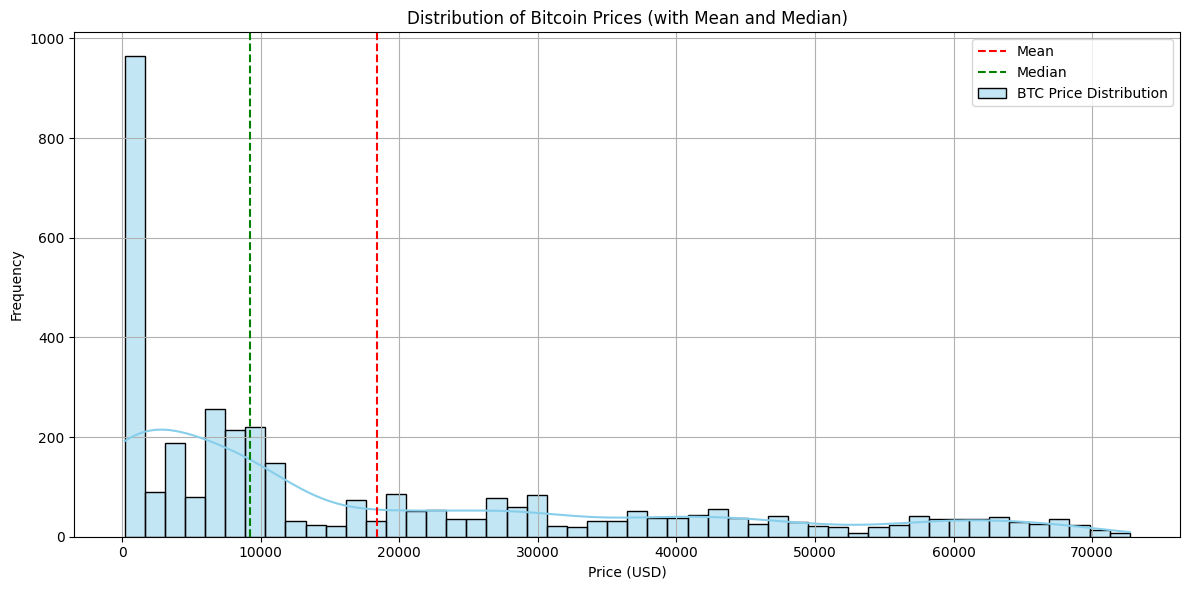

In [ ]:
#plot for Distribution of Bitcoin Price
plt.figure(figsize=(12, 6))
sns.histplot(btc['Close'], kde=True, bins=50, color='skyblue', label='BTC Price Distribution')
plt.axvline(btc['Close'].mean(), color='red', linestyle='dashed', label='Mean')
plt.axvline(btc['Close'].median(), color='green', linestyle='dashed', label='Median')
plt.title('Distribution of Bitcoin Prices (with Mean and Median)')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
btc

,Date,Adj Close,Close,High,Low,Open,Volume,profit,Daily_Price_Change
0,2014-09-17 00:00:00+00:00,457.3340148925781,457.334015,468.174011,452.421997,465.864014,21056800,Loss,-8.529999
1,2014-09-18 00:00:00+00:00,424.44000244140625,424.440002,456.859985,413.104004,456.859985,34483200,Loss,-32.419983
2,2014-09-19 00:00:00+00:00,394.7959899902344,394.795990,427.834991,384.532013,424.102997,37919700,Loss,-29.307007
3,2014-09-20 00:00:00+00:00,408.90399169921875,408.903992,423.295990,389.882996,394.673004,36863600,Profit,14.230988
4,2014-09-21 00:00:00+00:00,398.8210144042969,398.821014,412.425995,393.181000,408.084991,26580100,Loss,-9.263977
...,...,...,...,...,...,...,...,...,...
3694,2024-10-28 00:00:00+00:00,69907.7578125,69907.757812,70212.265625,67535.132812,67922.671875,38799856657,Profit,1985.085938
3695,2024-10-29 00:00:00+00:00,72720.4921875,72720.492188,73577.210938,69729.914062,69910.046875,58541874402,Profit,2810.445312
3696,2024-10-30 00:00:00+00:00,72339.5390625,72339.539062,72905.296875,71411.734375,72715.367188,40646637831,Loss,-375.828125
3697,2024-10-31 00:00:00+00:00,70215.1875,70215.187500,72662.312500,69590.500000,72335.046875,40627912076,Loss,-2119.859375


In [ ]:
print(btc)

                          Date           Adj Close         Close  \
0    2014-09-17 00:00:00+00:00   457.3340148925781    457.334015   
1    2014-09-18 00:00:00+00:00  424.44000244140625    424.440002   
2    2014-09-19 00:00:00+00:00   394.7959899902344    394.795990   
3    2014-09-20 00:00:00+00:00  408.90399169921875    408.903992   
4    2014-09-21 00:00:00+00:00   398.8210144042969    398.821014   
...                        ...                 ...           ...   
3694 2024-10-28 00:00:00+00:00       69907.7578125  69907.757812   
3695 2024-10-29 00:00:00+00:00       72720.4921875  72720.492188   
3696 2024-10-30 00:00:00+00:00       72339.5390625  72339.539062   
3697 2024-10-31 00:00:00+00:00          70215.1875  70215.187500   
3698 2024-11-01 00:00:00+00:00         70047.40625  70047.406250   

              High           Low          Open       Volume  profit  \
0       468.174011    452.421997    465.864014     21056800    Loss   
1       456.859985    413.104004    456.8

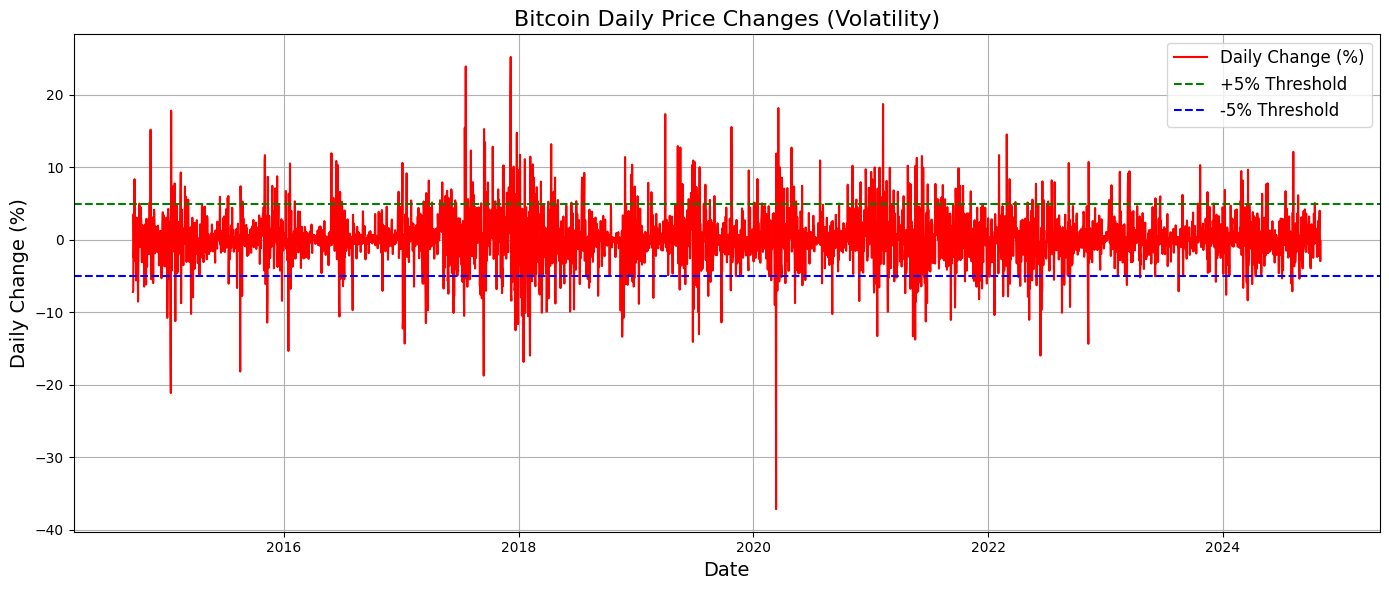

In [ ]:
# Add horizontal reference lines at ±5% and adjust color
daily_change = btc['Close'].pct_change() * 100
plt.figure(figsize=(14, 6))
plt.plot(btc['Date'], daily_change, color='red', label='Daily Change (%)')
plt.axhline(5, color='green', linestyle='--', label='+5% Threshold')
plt.axhline(-5, color='blue', linestyle='--', label='-5% Threshold')
plt.title('Bitcoin Daily Price Changes (Volatility)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Daily Change (%)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


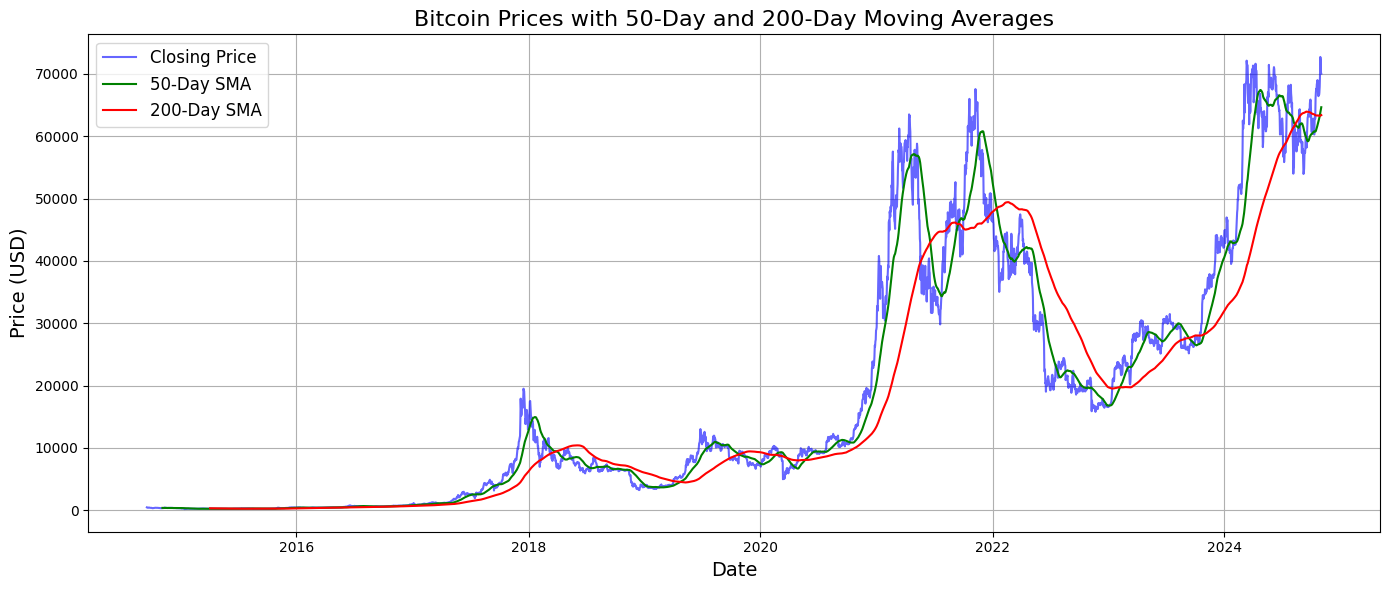

In [ ]:
# Add crossover points between 50-day and 200-day moving averages
btc['50-Day SMA'] = btc['Close'].rolling(window=50).mean()
btc['200-Day SMA'] = btc['Close'].rolling(window=200).mean()
plt.figure(figsize=(14, 6))
plt.plot(btc['Date'], btc['Close'], color='blue', label='Closing Price', alpha=0.6)
plt.plot(btc['Date'], btc['50-Day SMA'], color='green', label='50-Day SMA')
plt.plot(btc['Date'], btc['200-Day SMA'], color='red', label='200-Day SMA')
plt.title('Bitcoin Prices with 50-Day and 200-Day Moving Averages', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


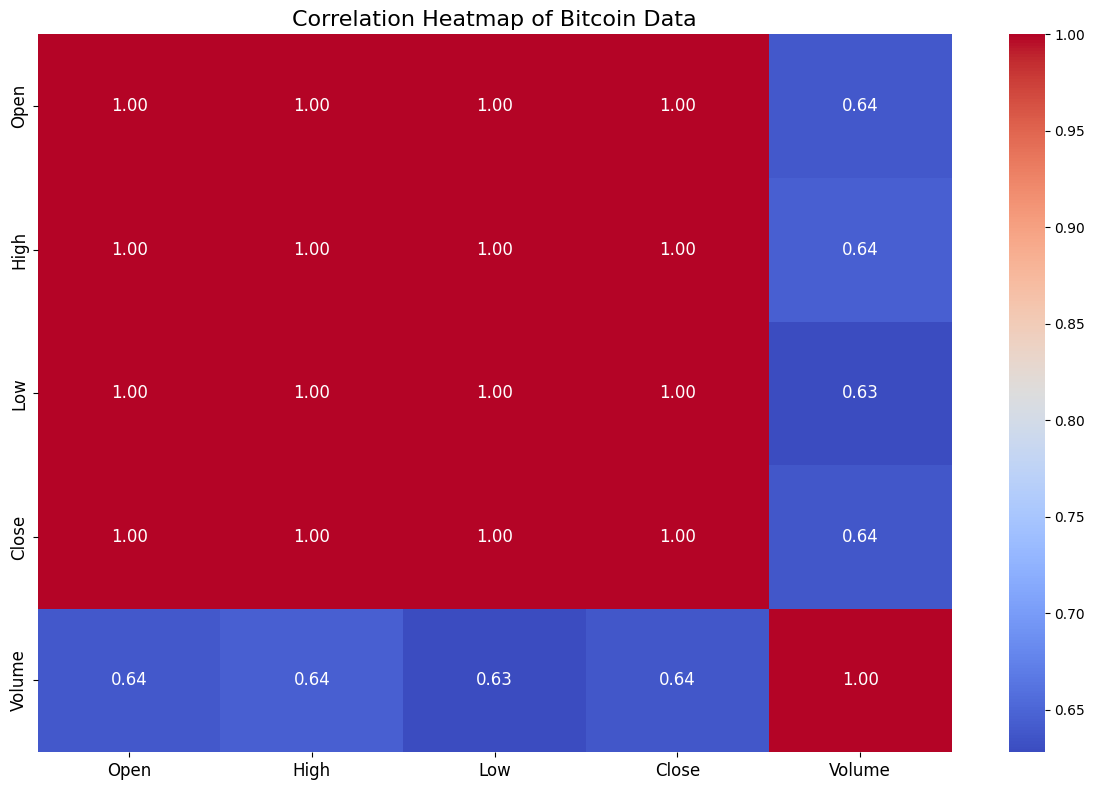

In [ ]:
#correlation values in the heatmap

plt.figure(figsize=(12, 8))
sns.heatmap(btc[['Open', 'High', 'Low', 'Close', 'Volume']].corr(), annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size': 12})
plt.title('Correlation Heatmap of Bitcoin Data', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


<ipython-input-36-d5e2fb239e7c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Year', y='Close', data=btc, palette='viridis')


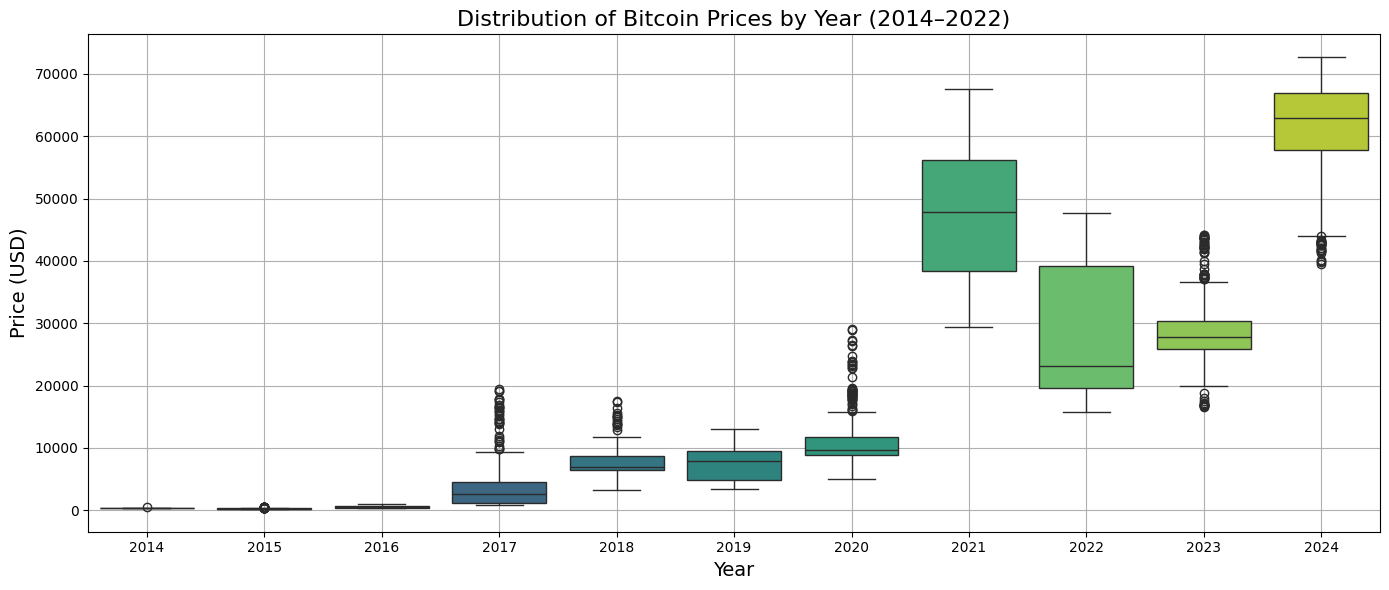

In [ ]:
# Add median labels and color gradient
btc['Year'] = btc['Date'].dt.year
plt.figure(figsize=(14, 6))
sns.boxplot(x='Year', y='Close', data=btc, palette='viridis')
plt.title('Distribution of Bitcoin Prices by Year (2014–2022)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


need to standardize the data to do this

In [ ]:
# Assuming `btc` is your DataFrame and 'diff' is the column to process
scaler = StandardScaler()

# Standardize the 'diff' column
btc['Standardized_diff'] = scaler.fit_transform(btc[['Daily_Price_Change']])

# Define bins and labels
bins = [-np.inf, -1.5, -0.5, 0.5, 1.5, np.inf]  # Adjust these values to reflect standardized data
labels = ['low Return', 'Below Avg Return', 'Avg Return', 'Abv Avg Return', 'High Return']

# Apply binning on the standardized 'diff'
btc['Count Category'] = pd.cut(btc['Standardized_diff'], bins, labels=labels)

# Group by Count Category and count
grouped_counts = btc.groupby('Count Category',observed = True).count()

# Display the results
print(grouped_counts.to_string(), end = "")

                  Date  Adj Close  Close  High   Low  Open  Volume  profit  Daily_Price_Change  Month  Daily Change (%)  Year-Month  50-Day SMA  200-Day SMA  Year  Standardized_diff
Count Category                                                                                                                                                                       
low Return         170        170    170   170   170   170     170     170                 170    170               170         170         170          170   170                170
Below Avg Return   297        297    297   297   297   297     297     297                 297    297               297         297         297          297   297                297
Avg Return        2735       2735   2735  2735  2735  2735    2735    2735                2735   2735              2734        2735        2686         2536  2735               2735
Abv Avg Return     319        319    319   319   319   319     319     319                

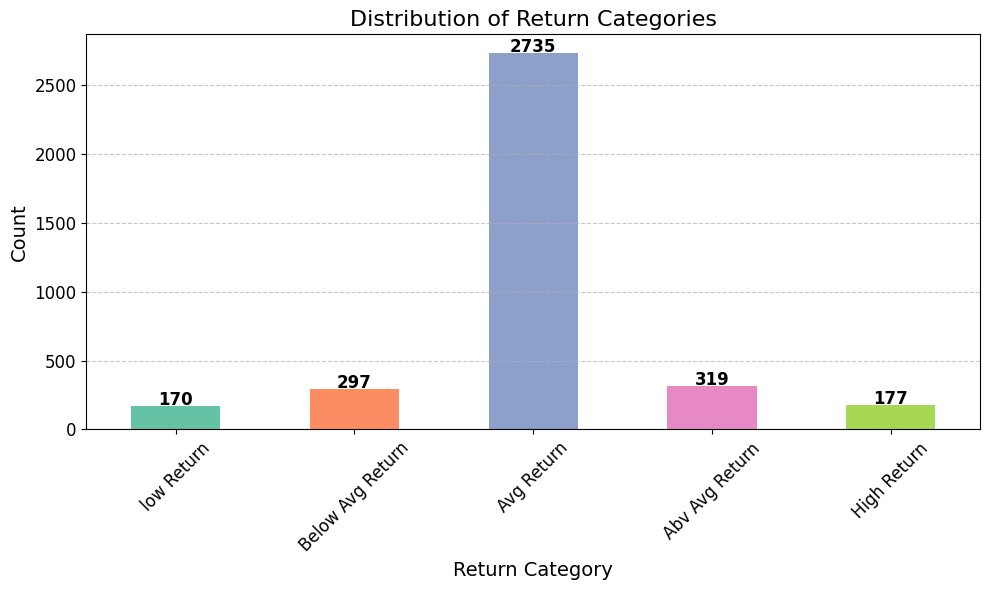

In [ ]:
# Bar plot for the return categories
plt.figure(figsize=(10, 6))
ax = btc['Count Category'].value_counts().sort_index().plot(kind='bar', color=sns.color_palette("Set2", 5))

# Add count labels on top of each bar
for i, count in enumerate(btc['Count Category'].value_counts().sort_index()):
    plt.text(i, count + 5, str(count), ha='center', fontsize=12, color='black', fontweight='bold')

# Customize the plot
plt.title('Distribution of Return Categories', fontsize=16)
plt.xlabel('Return Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

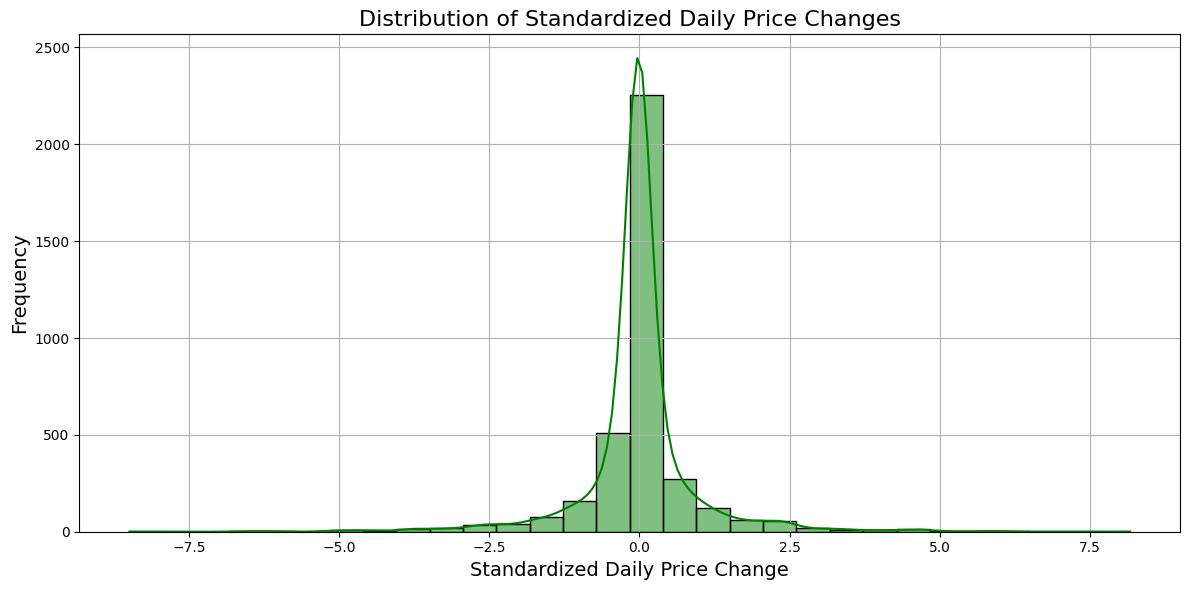

In [ ]:
# Histogram with KDE (Kernel Density Estimate)
plt.figure(figsize=(12, 6))
sns.histplot(btc['Standardized_diff'], kde=True, bins=30, color='green')
plt.title('Distribution of Standardized Daily Price Changes', fontsize=16)
plt.xlabel('Standardized Daily Price Change', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


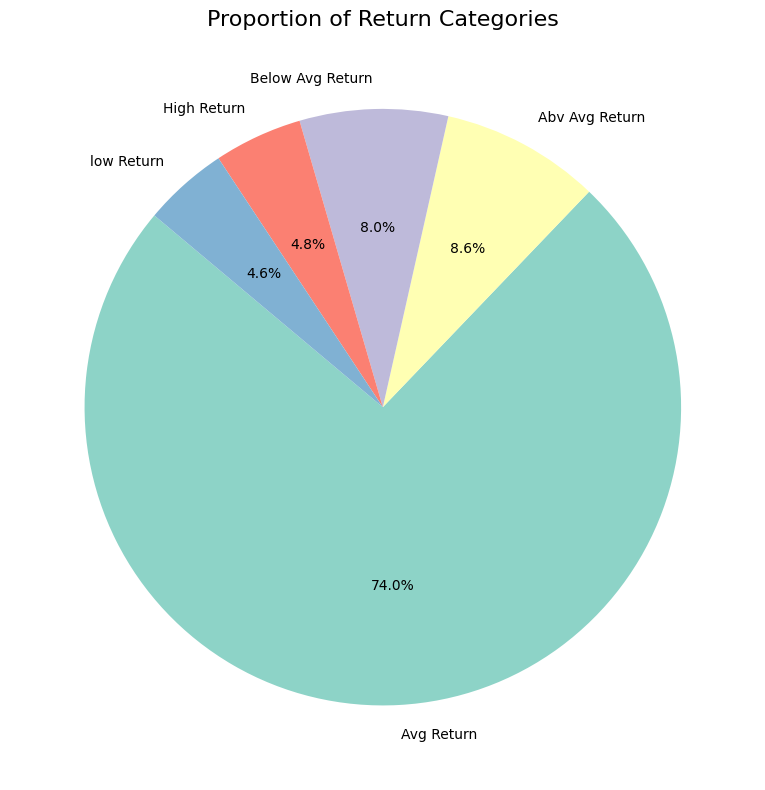

In [ ]:
# Pie chart for return categories
plt.figure(figsize=(8, 8))
btc['Count Category'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set3'))
plt.title('Proportion of Return Categories', fontsize=16)
plt.ylabel('')  # Remove y-label for a cleaner look
plt.tight_layout()
plt.show()


In [ ]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3698 entries, 0 to 3698
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   Date                3698 non-null   datetime64[ns, UTC]
 1   Adj Close           3698 non-null   object             
 2   Close               3698 non-null   float64            
 3   High                3698 non-null   float64            
 4   Low                 3698 non-null   float64            
 5   Open                3698 non-null   float64            
 6   Volume              3698 non-null   object             
 7   profit              3698 non-null   object             
 8   Daily_Price_Change  3698 non-null   float64            
 9   Month               3698 non-null   int32              
 10  Daily Change (%)    3697 non-null   float64            
 11  Year-Month          3698 non-null   period[M]          
 12  50-Day SMA          3649 non-null   flo

In [ ]:
btc.dtypes

,0
Date,"datetime64[ns, UTC]"
Adj Close,object
Close,float64
High,float64
Low,float64
Open,float64
Volume,object
profit,object
Daily_Price_Change,float64
Month,int32


SENTIMENT DATA

In [ ]:
# Load Kaggle dataset using Kaggle API and token

# List files in the current directory to check for the Kaggle token
os.listdir()

# Upload the Kaggle API key file (kaggle.json) to authenticate access
files.upload()

# Create a hidden folder for the Kaggle token
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Set proper permissions for the Kaggle token file for security
!chmod 600 ~/.kaggle/kaggle.json

# List all available datasets on Kaggle to explore options
!kaggle datasets list

# Download the Bitcoin tweets dataset using its Kaggle identifier
#!kaggle datasets download -d gauravduttakiit/bitcoin-tweets-16m-tweets-with-sentiment-tagged

# Unzip the dataset to access its contents
#!unzip bitcoin-tweets-16m-tweets-with-sentiment-tagged.zip




ref                                                              title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
stealthtechnologies/predict-student-performance-dataset          Predict Student Performance                          12KB  2024-12-26 12:57:04           1241         34  1.0              
bhadramohit/customer-shopping-latest-trends-dataset              Customer Shopping (Latest Trends) Dataset            76KB  2024-11-23 15:26:12          21697        404  1.0              
ankushpanday1/heart-attack-in-youth-of-india                     Heart attack in youth of India                      298KB  2025-01-02 15:20:31            806         25  1.0              
oktayrdeki/heart-disease                               

In [ ]:
# reading sentiment data
Sentiment = pd.read_csv('/content/mbsa.csv')

In [77]:
Sentiment.info()
Sentiment.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19344048 entries, 0 to 19344047
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   Date       object
 1   text       object
 2   Sentiment  object
dtypes: object(3)
memory usage: 442.8+ MB


,Date,text,Sentiment
count,19344048,19344029,18452904
unique,1917,14876177,3
top,2018-08-03,$EPAZ's Bitcoin Sharing &amp; Blockchain Socia...,Negative
freq,995986,891106,9729297


# MODELS

ARIMA MODEL
A statistical time series forecasting method called ARIMA (AutoRegressive Integrated Moving Average) makes predictions about future data points by using historical observations. Integrated (I), which makes the series stationary by differencing (parameter d); AutoRegressive (AR), which models relationships using lagged observations (controlled by parameter p); and Moving Average (MA), which models the relationship between observations and lagged forecast errors (parameter q). ARIMA is frequently used in financial forecasting because it effectively captures trends and patterns in univariate time series data.



In [ ]:
# Filter for dates between 2015 and 2020
btc5yrs = btc[(btc['Date'] >= '2015-01-01') & (btc['Date'] < '2019-12-31')].reset_index(drop = True)

btc_forecast = btc5yrs[['Date','Close','Open','High','Low']].reset_index(drop = True)

btc_forecast.head(5)

,Date,Close,Open,High,Low
0,2015-01-01 00:00:00+00:00,314.248993,320.434998,320.434998,314.002991
1,2015-01-02 00:00:00+00:00,315.032013,314.079010,315.838989,313.565002
2,2015-01-03 00:00:00+00:00,281.082001,314.846008,315.149994,281.082001
3,2015-01-04 00:00:00+00:00,264.195007,281.145996,287.230011,257.612000
4,2015-01-05 00:00:00+00:00,274.473999,265.084015,278.341003,265.084015


In [ ]:
scaler = StandardScaler()
columns_to_standardize = ['Open', 'High', 'Low', 'Close']
scaler.fit(btc_forecast[columns_to_standardize])

StandardScaler()

In [ ]:
btc_forecast.head(5)

,Date,Close,Open,High,Low
0,2015-01-01 00:00:00+00:00,314.248993,320.434998,320.434998,314.002991
1,2015-01-02 00:00:00+00:00,315.032013,314.079010,315.838989,313.565002
2,2015-01-03 00:00:00+00:00,281.082001,314.846008,315.149994,281.082001
3,2015-01-04 00:00:00+00:00,264.195007,281.145996,287.230011,257.612000
4,2015-01-05 00:00:00+00:00,274.473999,265.084015,278.341003,265.084015


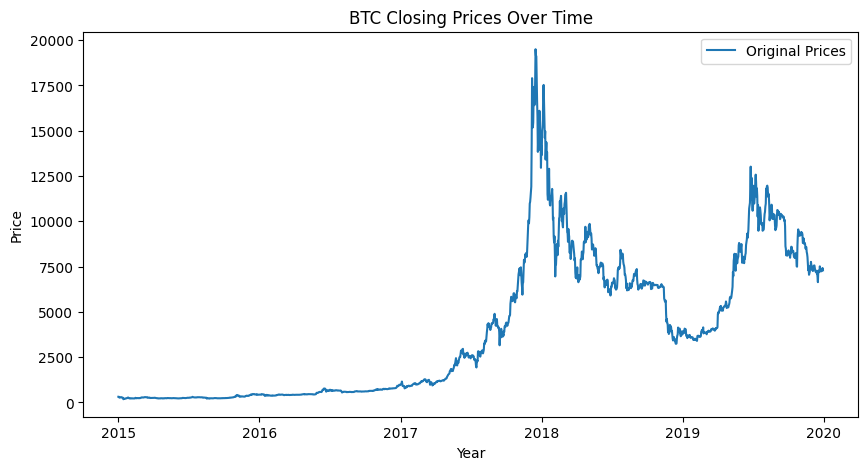

In [ ]:
# Plot the original time series
plt.figure(figsize=(10, 5))
plt.plot(btc_forecast['Date'],btc_forecast['Close'], label='Original Prices')
plt.title('BTC Closing Prices Over Time')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()

check for stationary of time series


<Figure size 1200x600 with 0 Axes>

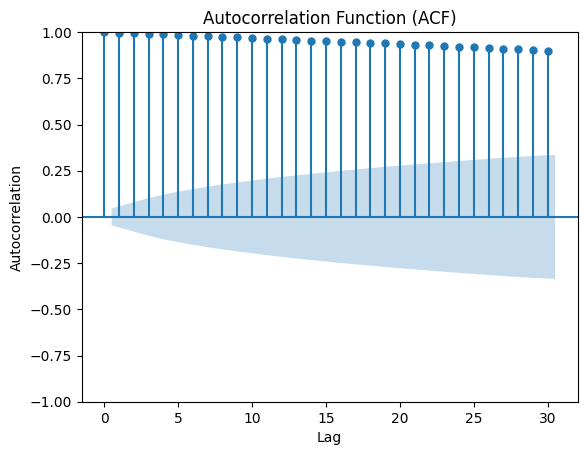

<Figure size 1200x600 with 0 Axes>

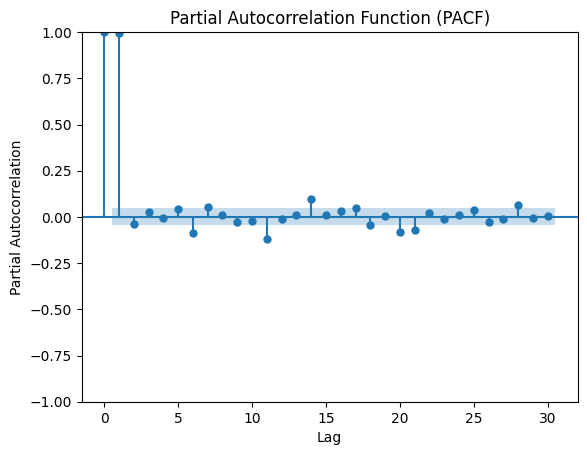

In [ ]:
#plotting ACF and PACF after transforming
# 1. Plot the ACF
plt.figure(figsize=(12, 6))
plot_acf(btc_forecast['Close'], lags=30, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# 2. Plot the PACF
plt.figure(figsize=(12, 6))
plot_pacf(btc_forecast['Close'], lags=30, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

Transforming the data to stationary by differencing

In [ ]:
import pandas as pd

def double_difference(data, column_name):
    """
    Apply double differencing to make a time series stationary.

    Parameters:
    - data (pd.DataFrame): DataFrame containing the time series.
    - column_name (str): The name of the column to be differenced.

    Returns:
    - pd.Series: The double differenced series.
    """
    # First difference
    first_diff = data[column_name].diff()

    # Second difference (double differencing)
    second_diff = first_diff.diff()

    return second_diff


In [ ]:
btc["Double_Diff"] = double_difference(btc, 'Close')
print(btc)


                          Date           Adj Close         Close  \
0    2014-09-17 00:00:00+00:00   457.3340148925781    457.334015   
1    2014-09-18 00:00:00+00:00  424.44000244140625    424.440002   
2    2014-09-19 00:00:00+00:00   394.7959899902344    394.795990   
3    2014-09-20 00:00:00+00:00  408.90399169921875    408.903992   
4    2014-09-21 00:00:00+00:00   398.8210144042969    398.821014   
...                        ...                 ...           ...   
3694 2024-10-28 00:00:00+00:00       69907.7578125  69907.757812   
3695 2024-10-29 00:00:00+00:00       72720.4921875  72720.492188   
3696 2024-10-30 00:00:00+00:00       72339.5390625  72339.539062   
3697 2024-10-31 00:00:00+00:00          70215.1875  70215.187500   
3698 2024-11-01 00:00:00+00:00         70047.40625  70047.406250   

              High           Low          Open       Volume  profit  \
0       468.174011    452.421997    465.864014     21056800    Loss   
1       456.859985    413.104004    456.8

In [ ]:
# Drop NaN values
btc = btc.dropna()




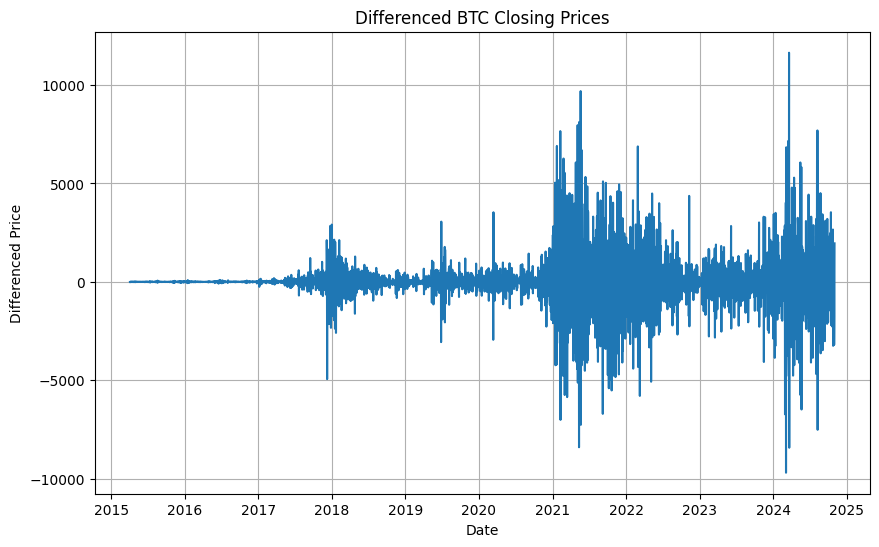

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(btc['Date'], btc['Double_Diff'])
plt.title('Differenced BTC Closing Prices')
plt.xlabel('Date')
plt.ylabel('Differenced Price')
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

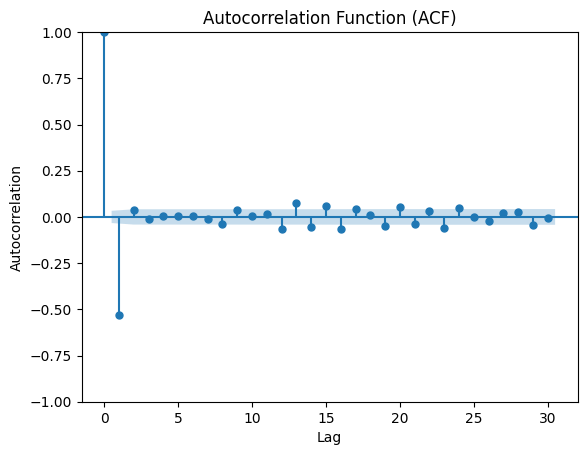

<Figure size 1200x600 with 0 Axes>

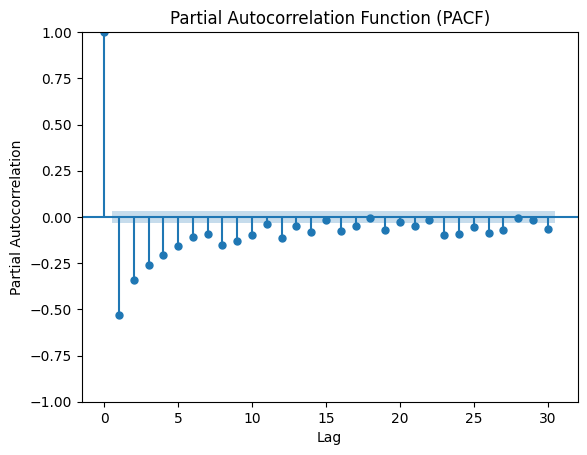

In [ ]:
#plotting ACF and PACF after transforming
# 1. Plot the ACF
plt.figure(figsize=(12, 6))
plot_acf(btc['Double_Diff'], lags=30, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# 2. Plot the PACF
plt.figure(figsize=(12, 6))
plot_pacf(btc['Double_Diff'], lags=30, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [ ]:
# Augmented Dickey-Fuller Test for Stationarity
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'ADF Test for {title}')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    if result[1] <= 0.05:
        print("Conclusion: The data is stationary.")
    else:
        print("Conclusion: The data is not stationary.")

# Run the ADF test on original and differenced series
adf_test(btc['Close'], title='Original data')
#adf_test(btc_forecast['Close'], title='Original Closing Prices')
#adf_test(btc_forecast['diff'], title='Differenced Closing Prices')

ADF Test for Original data
ADF Statistic: -0.6183982730729977
p-value: 0.8667703437505869
Critical Values:
   1%: -3.432235920478648
   5%: -2.862373292074422
   10%: -2.5672135762276906
Conclusion: The data is not stationary.


In [ ]:
adf_test(btc['Double_Diff'], title='Original data')

ADF Test for Original data
ADF Statistic: -20.25232664864797
p-value: 0.0
Critical Values:
   1%: -3.4322364645313335
   5%: -2.862373532387402
   10%: -2.567213704163575
Conclusion: The data is stationary.


In [ ]:
#splitting into training and test data
train_size = int(len(btc) * 0.8)
train_data = btc[:train_size]
test_data = btc[train_size:]

In [ ]:
np.random.seed(42)
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
max_p = 4
max_d = 2
max_q = 4
def find_best_aic_model(data, max_p, max_d, max_q):
    best_aic = np.inf
    best_model = None
    best_order = None
    for p, d, q in product(range(max_p + 1), range(max_d + 1), range(max_q + 1)):
        try:
            model = SARIMAX(data, order=(p, d, q), enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            aic = model_fit.aic
            if aic < best_aic:
                best_aic = aic
                best_model = model_fit
                best_order = (p, d, q)
        except Exception as e:
            continue
    return best_order, best_aic

best_order, best_aic = find_best_aic_model(train_data['Close'], max_p, max_d, max_q)
print("Best Order:", best_order)
print("Best AIC:", best_aic)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot

Best Order: (2, 2, 4)
Best AIC: 45436.58044200842


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2799 entries, 199 to 2997
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   Date                2799 non-null   datetime64[ns, UTC]
 1   Adj Close           2799 non-null   object             
 2   Close               2799 non-null   float64            
 3   High                2799 non-null   float64            
 4   Low                 2799 non-null   float64            
 5   Open                2799 non-null   float64            
 6   Volume              2799 non-null   object             
 7   profit              2799 non-null   object             
 8   Daily_Price_Change  2799 non-null   float64            
 9   Month               2799 non-null   int32              
 10  Daily Change (%)    2799 non-null   float64            
 11  Year-Month          2799 non-null   period[M]          
 12  50-Day SMA          2799 non-null   f

In [ ]:

# Fit ARIMA model on the training dataset
model = ARIMA(train_data['Close'], order=best_order,exog = train_data[['Open', 'High', 'Low']])  # Adjust (p, d, q) based on previous analysis
model_fit = model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

In [ ]:

# Forecast for the test period
forecast = model_fit.forecast(steps=len(test_data),exog = test_data[['Open', 'High', 'Low']])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
forecast_index = pd.date_range(start=pd.to_datetime(test_data.index[0]) + pd.Timedelta(days=1), periods=len(test_data), freq='D')

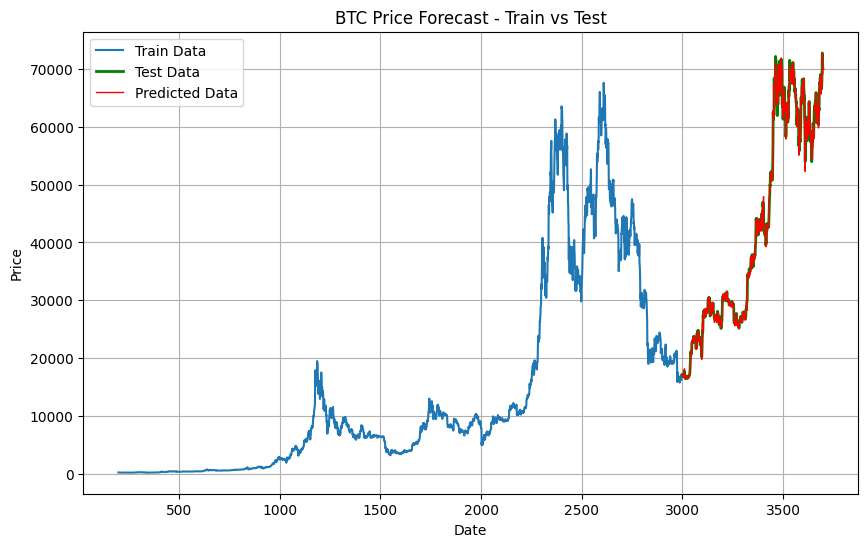

In [ ]:

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['Close'], label="Train Data") # Access Close column from train_data DataFrame
plt.plot(test_data.index, test_data['Close'], label="Test Data",color = 'green',linewidth = '2')  # Access Close column from test_data DataFrame
plt.plot(test_data.index, forecast, label="Predicted Data", color='red',linewidth = '1')
plt.title("BTC Price Forecast - Train vs Test")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_i

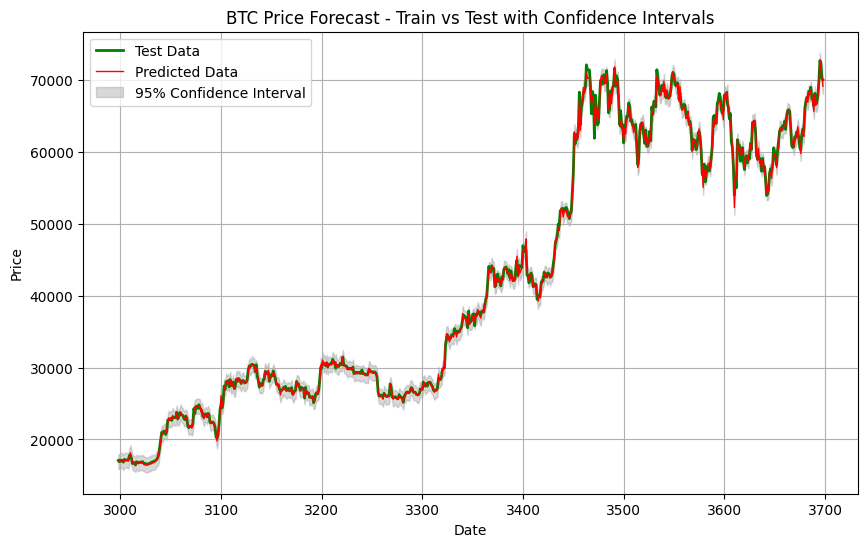

In [ ]:
# Assuming best_results is an ARIMA model result
# Forecast on test data
forecast = model_fit.forecast(
    steps=len(test_data),
    exog=test_data[["Open", "High", "Low"]],  # Exogenous variables (if any)
    alpha=0.05,  # 95% confidence level
)

# Get confidence intervals separately
conf_int = model_fit.get_forecast(steps=len(test_data), exog=test_data[["Open", "High", "Low"]]).conf_int(alpha=0.05)

# Plot train, test, and forecast data
plt.figure(figsize=(10, 6))
#plt.plot(train_data.index, train_data["Close"], label="Train Data")
plt.plot(test_data.index, test_data["Close"], label="Test Data", color="green", linewidth=2)
plt.plot(test_data.index, forecast, label="Predicted Data", color="red", linewidth=1)

# Fill the confidence interval area
# Access confidence intervals using column names
plt.fill_between(
    test_data.index,
    conf_int['lower Close'],  # Lower bound of confidence interval # Changed to column name
    conf_int['upper Close'],  # Upper bound of confidence interval # Changed to column name
    color="gray",
    alpha=0.3,
    label="95% Confidence Interval",
)

# Enhance the plot
plt.title("BTC Price Forecast - Train vs Test with Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

In [ ]:


# Evaluate the model performance
mse = mean_squared_error(test_data['Close'], forecast)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_data['Close'], forecast)
r2 = r2_score(test_data['Close'], forecast)  # Calculate R-squared

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")
print(f"R-squared (R²): {r2}")

Mean Squared Error (MSE): 182420.211792928
Root Mean Squared Error (RMSE): 427.1067920238778
Mean Absolute Percentage Error (MAPE): 0.67%
R-squared (R²): 0.9994247854306466


LSTM
A specific kind of recurrent neural network (RNN) called long short-term memory (LSTM) is made to represent sequential data and identify long-term dependencies. By employing a gated architecture that controls the information flow through three crucial gates—the forget gate, input gate, and output gate—LSTMs, in contrast to conventional RNNs, solve the issue of vanishing and bursting gradients. These gates assist LSTMs in eliminating superfluous data and retaining important information over lengthy sequences. LSTMs are perfect for tasks like Bitcoin price predictions because of their exceptional efficacy in handling time series data. They can forecast future values based on historical data because they can learn intricate, non-linear patterns and temporal correlations.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
37/37 - 7s - 185ms/step - loss: 0.0162 - val_loss: 7.9784e-04
Epoch 2/100
37/37 - 1s - 20ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 3/100
37/37 - 0s - 7ms/step - loss: 9.2612e-04 - val_loss: 5.7417e-04
Epoch 4/100
37/37 - 0s - 8ms/step - loss: 8.4968e-04 - val_loss: 6.2510e-04
Epoch 5/100
37/37 - 0s - 9ms/step - loss: 7.7851e-04 - val_loss: 5.6270e-04
Epoch 6/100
37/37 - 0s - 6ms/step - loss: 7.1525e-04 - val_loss: 4.7144e-04
Epoch 7/100
37/37 - 0s - 7ms/step - loss: 6.8304e-04 - val_loss: 4.8648e-04
Epoch 8/100
37/37 - 0s - 6ms/step - loss: 6.2927e-04 - val_loss: 4.0657e-04
Epoch 9/100
37/37 - 0s - 6ms/step - loss: 6.2302e-04 - val_loss: 5.2831e-04
Epoch 10/100
37/37 - 0s - 9ms/step - loss: 6.0690e-04 - val_loss: 5.3691e-04
Epoch 11/100
37/37 - 0s - 7ms/step - loss: 5.6837e-04 - val_loss: 4.7208e-04
Epoch 12/100
37/37 - 0s - 9ms/step - loss: 5.4718e-04 - val_loss: 3.5880e-04
Epoch 13/100
37/37 - 0s - 8ms/step - loss: 5.3267e-04 - val_loss: 4.7840e-04
Epoch 14/100
37/3

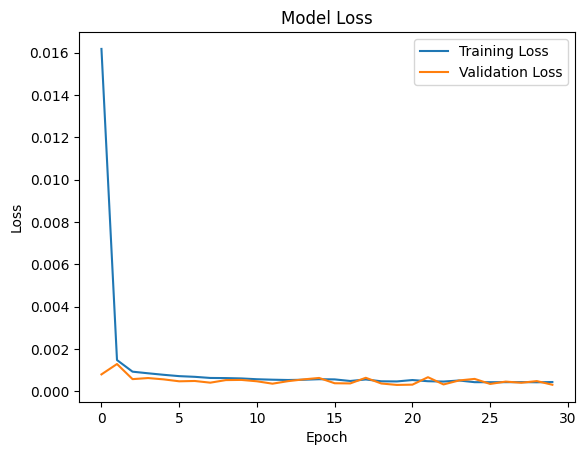

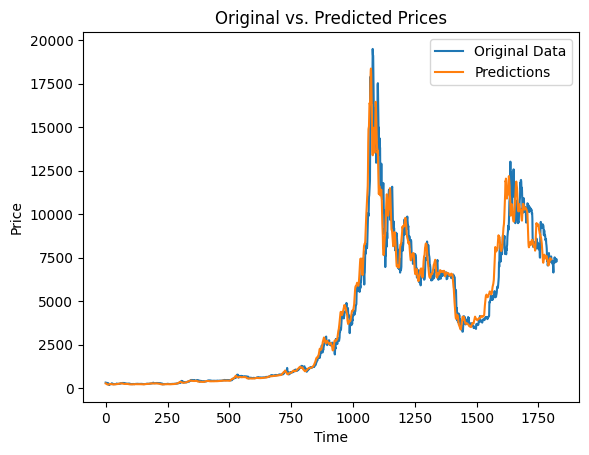

In [ ]:
# Extracting the series
data_series = btc_forecast['Close'].values.reshape(-1, 1)

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data_series)

# Split the data into training and testing sets (adjust split ratio if needed)
train_size = int(len(data_normalized) * 0.8)  # Increased train size to 80%
test_size = len(data_normalized) - train_size
train, test = data_normalized[0:train_size], data_normalized[train_size:len(data_normalized)]

# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Reshape into X=t and Y=t+1 (experiment with different look_back values)
look_back = 10  # Increased look_back to 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))  # Reshaped for LSTM input
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# Define a function to create the LSTM model (to be used in hyperparameter tuning)
def create_lstm_model(units=50, activation='relu', optimizer='adam'):  # Added parameters for tuning
    model = Sequential()
    model.add(LSTM(units, activation=activation, input_shape=(look_back, 1)))  # Modified LSTM layer
    model.add(Dense(1))
    optimizer = Adam(learning_rate = 0.001)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Create the LSTM model
model = create_lstm_model()  # Now using the function

# Add Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10)  # Stop if val_loss doesn't improve for 10 epochs

# Train the model (adjust epochs and batch_size)
history = model.fit(
    trainX, trainY,
    epochs=100,
    batch_size=32,  # Increased batch size
    validation_split=0.2,  # Added validation split for monitoring overfitting
    callbacks=[early_stopping],  # Added Early Stopping
    verbose=2
)

# Make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])

# Calculate and print RMSE
train_score = np.sqrt(mean_squared_error(trainY[0], train_predict[:, 0]))
print(f'Train Score: {train_score:.2f} RMSE')
test_score = np.sqrt(mean_squared_error(testY[0], test_predict[:, 0]))
print(f'Test Score: {test_score:.2f} RMSE')

# Plot training history (loss)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


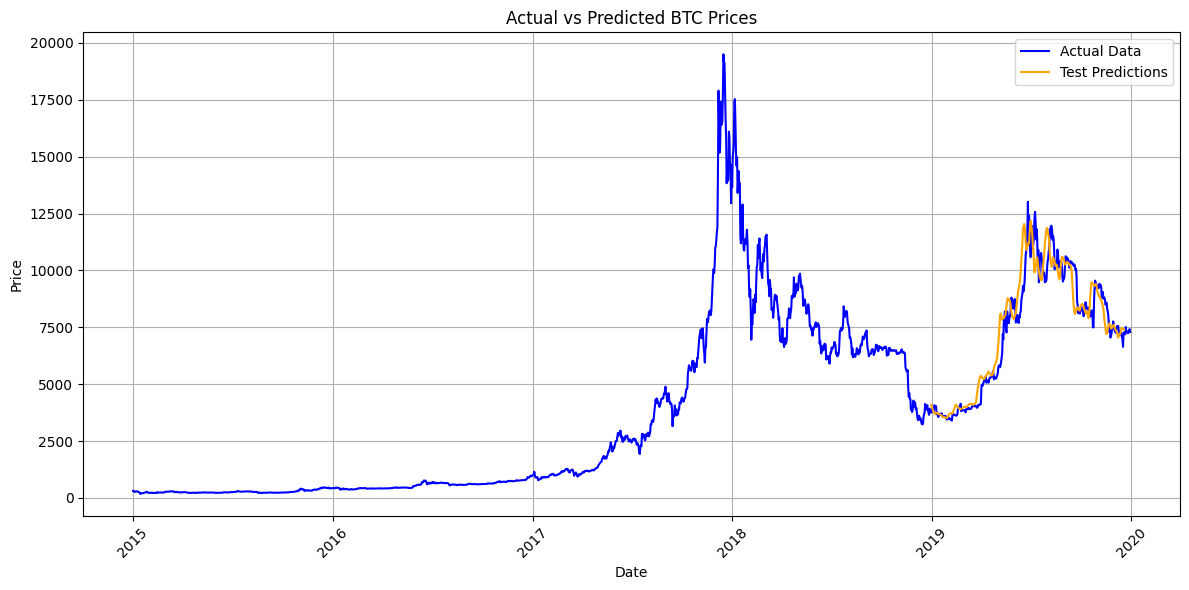

In [ ]:
# Prepare the actual and predicted data for plotting
train_dates = btc_forecast['Date'][:train_size]  # Dates for the training set

# Adjust the train_dates to match the size of train_predict
train_dates = train_dates[look_back + 1:train_size] # Adjust train_dates

test_dates = btc_forecast['Date'][train_size:train_size + len(test_predict)]  # Dates for the testing set

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(btc_forecast['Date'], scaler.inverse_transform(data_normalized), label='Actual Data', color='blue')  # Full actual data
#plt.plot(train_dates, train_predict, label='Train Predictions', color='green')  # Predictions on the training set
plt.plot(test_dates, test_predict, label='Test Predictions', color='orange')  # Predictions on the testing set

# Labeling and formatting
plt.title('Actual vs Predicted BTC Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [ ]:
btc_forecast.tail()

,Date,Close,Open,High,Low
1820,2019-12-26 00:00:00+00:00,7238.966797,7274.799316,7388.302734,7200.386719
1821,2019-12-27 00:00:00+00:00,7290.088379,7238.141113,7363.529297,7189.934082
1822,2019-12-28 00:00:00+00:00,7317.990234,7289.031250,7399.041016,7286.905273
1823,2019-12-29 00:00:00+00:00,7422.652832,7317.647461,7513.948242,7279.865234
1824,2019-12-30 00:00:00+00:00,7292.995117,7420.272949,7454.824219,7276.308105


In [ ]:
history.epoch[-1]

29

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<ipython-input-68-2c91e5b6ab62>:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=btc_forecast['Date'].iloc[-1], periods=future_steps + 1, freq='M')[1:] # Use btc_forecast['Date'] for date range


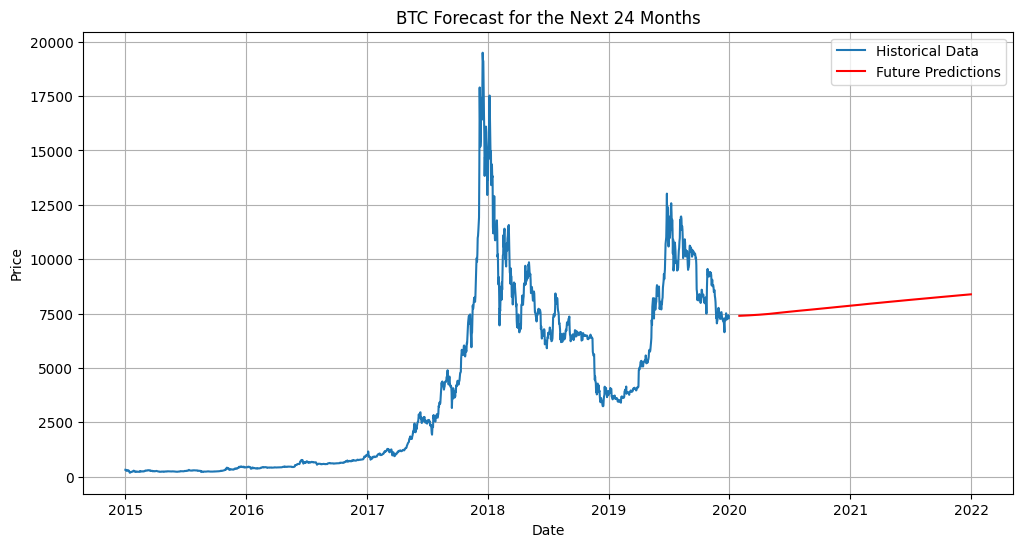

In [ ]:
# Number of future months to predict
future_steps = 24

# Initialize array for storing future predictions
future_predictions = np.empty((future_steps, 1))

# Start with the last time step from your test set
current_step = testX[-1, :, :]  # Use the last time step from your test data

for i in range(future_steps):
    # Reshape input data for the model (samples, time steps, features)
    current_step_reshaped = np.reshape(current_step, (1, current_step.shape[0], 1))  # Shape: (1, look_back, 1)
    # Predict the next step
    next_step = model.predict(current_step_reshaped)
    # Store the prediction
    future_predictions[i] = next_step
    # Update the current step by appending the predicted value and removing the oldest value
    current_step = np.append(current_step[1:], next_step).reshape(-1, 1)

# Transform predictions back to the original scale
future_predictions = scaler.inverse_transform(future_predictions)

# Plot the predictions
plt.figure(figsize=(12, 6))
# Replace scaled_data with data_normalized
plt.plot(btc_forecast['Date'], scaler.inverse_transform(data_normalized), label='Historical Data')  # Historical BTC data
future_dates = pd.date_range(start=btc_forecast['Date'].iloc[-1], periods=future_steps + 1, freq='M')[1:] # Use btc_forecast['Date'] for date range
#plt.plot(btc_forecast['Date'],np.concatenate([train_predict, test_predict]), label='Predictions')
plt.plot(future_dates, future_predictions, label='Future Predictions', color='red')
plt.legend()
plt.title('BTC Forecast for the Next 24 Months')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.show()

In [ ]:
# For evaluating future predictions
# Calculate and print RMSE, MAPE, R-squared
mse = mean_squared_error(testY[0], test_predict[:, 0])
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(testY[0], test_predict[:, 0])
r2 = r2_score(testY[0], test_predict[:, 0])  # Calculate R-squared

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")
print(f"R-squared (R²): {r2}")

Mean Squared Error (MSE): 156234.36475638434
Root Mean Squared Error (RMSE): 395.2649298336299
Mean Absolute Percentage Error (MAPE): 3.43%
R-squared (R²): 0.9771854116086409


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 - 6s - 175ms/step - loss: 0.0187 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 2/50
37/37 - 1s - 30ms/step - loss: 0.0018 - val_loss: 4.3693e-04 - learning_rate: 0.0010
Epoch 3/50
37/37 - 0s - 7ms/step - loss: 0.0018 - val_loss: 4.9080e-04 - learning_rate: 0.0010
Epoch 4/50
37/37 - 0s - 7ms/step - loss: 0.0014 - val_loss: 3.9334e-04 - learning_rate: 0.0010
Epoch 5/50

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
37/37 - 0s - 7ms/step - loss: 0.0017 - val_loss: 3.8087e-04 - learning_rate: 0.0010
Epoch 6/50
37/37 - 0s - 8ms/step - loss: 0.0013 - val_loss: 4.9339e-04 - learning_rate: 5.0000e-04
Epoch 7/50
37/37 - 0s - 8ms/step - loss: 0.0015 - val_loss: 5.0331e-04 - learning_rate: 5.0000e-04
Epoch 8/50

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
37/37 - 0s - 7ms/step - loss: 0.0013 - val_loss: 5.0300e-04 - learning_rate: 5.0000e-04
Epoch 9/50
37/37 - 0s - 7ms/step - loss: 0.0013 - val_loss: 4.8625e-04 - learning_rate

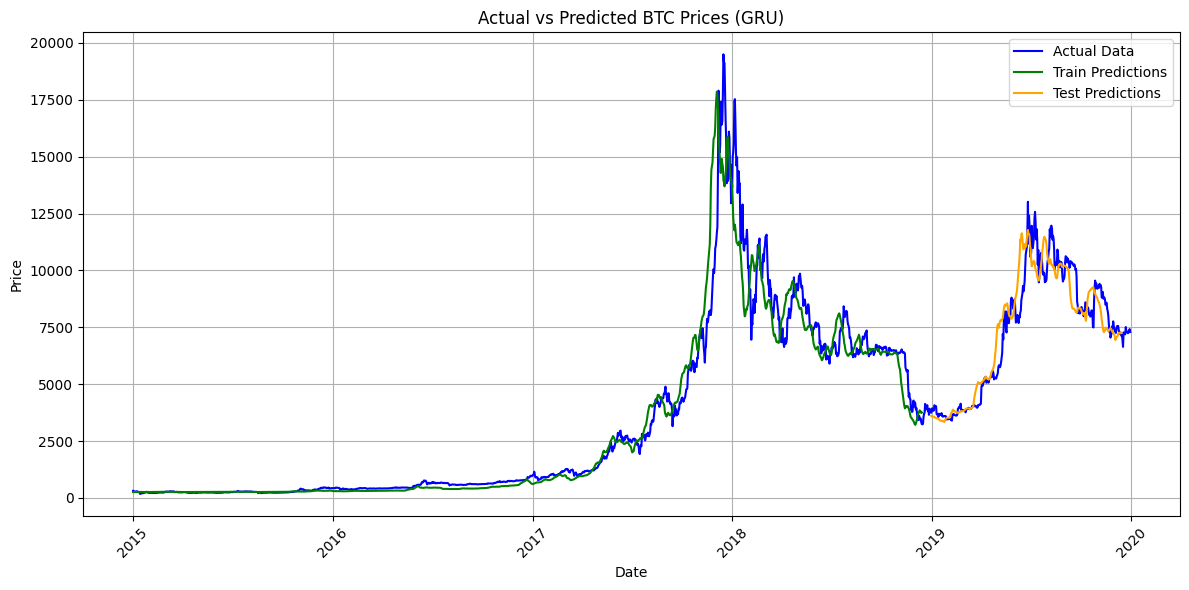

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


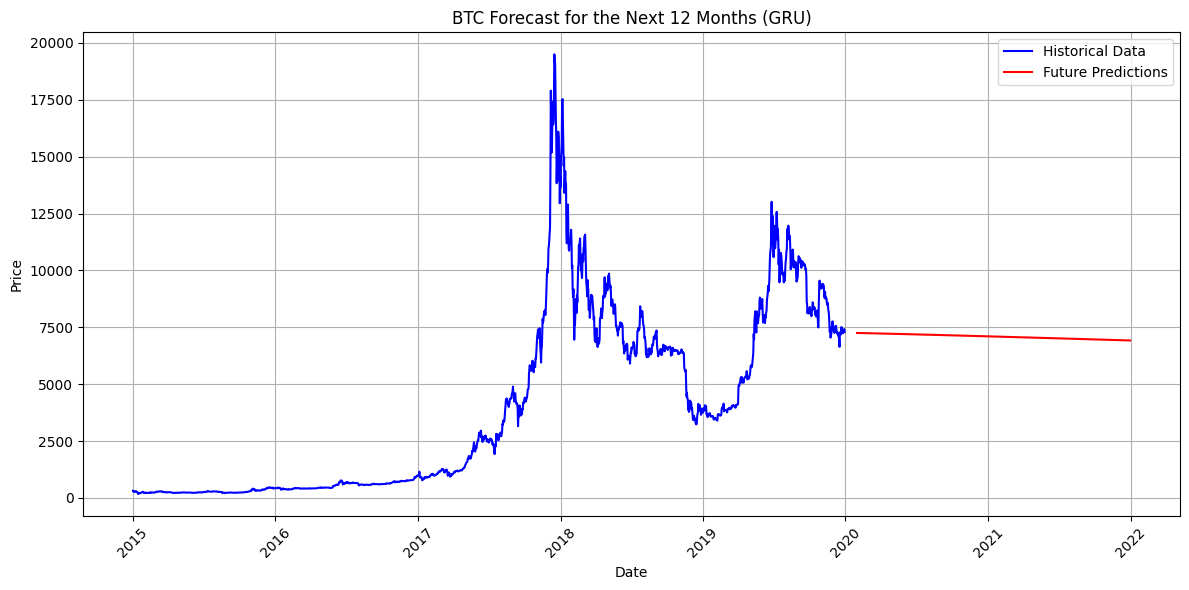

In [ ]:
# Extracting the series
data_series = btc_forecast['Close'].values.reshape(-1, 1)
dates_series = btc_forecast['Date']  # Extract dates for plotting

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data_series)

# Split the data into training and testing sets
train_size = int(len(data_normalized) * 0.8)  # 80% for training
train, test = data_normalized[0:train_size], data_normalized[train_size:len(data_normalized)]

# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Reshape into X=t and Y=t+1
look_back = 15  # Look-back period set to 15 for better temporal context
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# Define a GRU model
def create_gru_model(units=64, activation='relu', dropout_rate=0.2, optimizer='adam'):
    model = Sequential()
    # GRU Layer
    model.add(GRU(units, activation=activation, return_sequences=False, input_shape=(look_back, 1)))
    model.add(Dropout(dropout_rate))  # Dropout for regularization
    # Dense Layer
    model.add(Dense(1))  # Output layer
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Create the GRU model
gru_model = create_gru_model(units=100, dropout_rate=0.3)  # Adjusted units and dropout for improved learning

# Add Early Stopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Stops when no improvement
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)  # Reduces learning rate

# Train the model
history = gru_model.fit(
    trainX, trainY,
    epochs=50,  # Optimized to avoid overfitting
    batch_size=32,
    validation_split=0.2,  # Validation for monitoring overfitting
    callbacks=[early_stopping, reduce_lr],  # Add callbacks
    verbose=2
)

# Make predictions
train_predict = gru_model.predict(trainX)
test_predict = gru_model.predict(testX)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])

# Evaluate the model using RMSE and R²
train_rmse = np.sqrt(mean_squared_error(trainY[0], train_predict[:, 0]))
test_rmse = np.sqrt(mean_squared_error(testY[0], test_predict[:, 0]))
train_r2 = r2_score(trainY[0], train_predict[:, 0])
test_r2 = r2_score(testY[0], test_predict[:, 0])

print(f'Train RMSE: {train_rmse:.2f}, R²: {train_r2:.2f}')
print(f'Test RMSE: {test_rmse:.2f}, R²: {test_r2:.2f}')

# Plot actual vs predicted with dates
train_dates = dates_series[:train_size - look_back - 1]  # Dates for training predictions
test_dates = dates_series[train_size:train_size + len(test_predict)]  # Dates for testing predictions

plt.figure(figsize=(12, 6))
plt.plot(dates_series, scaler.inverse_transform(data_normalized), label='Actual Data', color='blue')  # Actual data
plt.plot(train_dates, train_predict, label='Train Predictions', color='green')  # Train predictions
plt.plot(test_dates, test_predict, label='Test Predictions', color='orange')  #

# Formatting the plot
plt.title('Actual vs Predicted BTC Prices (GRU)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)  # Rotate dates for readability
plt.grid(True)
plt.tight_layout()
plt.show()

# Forecast future predictions for 1 year (12 months)
future_steps = 24
future_predictions = np.empty((future_steps, 1))

# Use the last test data point as the starting point
current_step = testX[-1]

for i in range(future_steps):
    current_step_reshaped = np.reshape(current_step, (1, look_back, 1))  # Reshape for GRU input
    next_step = gru_model.predict(current_step_reshaped)  # Predict the next value
    future_predictions[i] = next_step  # Store the prediction
    # Update the current step by appending the predicted value and removing the oldest one
    current_step = np.append(current_step[1:], next_step).reshape(-1, 1)

# Transform future predictions back to original scale
future_predictions = scaler.inverse_transform(future_predictions)

# Create future dates
future_dates = pd.date_range(start=dates_series.iloc[-1], periods=future_steps + 1, freq='ME')[1:]

# Plot future predictions
plt.figure(figsize=(12, 6))
plt.plot(dates_series, scaler.inverse_transform(data_normalized), label='Historical Data', color='blue')
plt.plot(future_dates, future_predictions, label='Future Predictions', color='red')
plt.title('BTC Forecast for the Next 12 Months (GRU)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Ensure 'Date' column is in datetime format and remove timezone
sentiment_data['Date'] = pd.to_datetime(sentiment_data['Date'], errors='coerce')
btc['Date'] = pd.to_datetime(btc['Date']).dt.tz_localize(None)

# Filter for the year 2017
sentiment_data_2017 = sentiment_data[sentiment_data['Date'].dt.year == 2017].copy()
btc_data_2017 = btc[btc['Date'].dt.year == 2017].copy()

# Preprocess sentiment text
nltk.download('stopwords')
nltk.download('punkt')
# Download 'punkt_tab' data for English
nltk.download('punkt_tab')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove URLs, special characters, and numbers
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()

    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize words
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(tokens)

sentiment_data_2017['Cleaned_Text'] = sentiment_data_2017['text'].apply(preprocess_text)

# Map Sentiment to numeric scores (if necessary)
sentiment_mapping = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
sentiment_data_2017['Sentiment_Score'] = sentiment_data_2017['Sentiment'].map(sentiment_mapping)

# Aggregate sentiment scores by date
sentiment_agg = sentiment_data_2017.groupby('Date').agg({
    'Sentiment_Score': 'mean'
}).reset_index()

# Merge sentiment and BTC price data
merged_data_2017 = pd.merge(sentiment_agg, btc_data_2017, on='Date', how='inner')


In [ ]:
merged_data_2017 = merged_data_2017.reset_index(drop = True)
merged_data_2017 = merged_data_2017.sort_values(by='Date',ascending = True)

In [ ]:
# Enhanced Visualization of Sentiment and BTC Price Trends
plt.figure(figsize=(14, 8))

# Plot BTC Price
sns.lineplot(data=merged_data_2017, x='Date', y='Close', label='BTC Price', color='orange', linewidth=2.5)

# Create a secondary y-axis for sentiment
ax1 = plt.gca()  # Primary y-axis (BTC Price)
ax2 = ax1.twinx()  # Secondary y-axis (Sentiment)

# Plot Sentiment Score on secondary y-axis
sns.lineplot(data=merged_data_2017, x='Date', y='Sentiment_Score', label='Sentiment Score', ax=ax2, color='blue', linewidth=2.5)

# Add markers for better readability
ax1.scatter(merged_data_2017['Date'], merged_data_2017['Close'], color='orange', s=10)
ax2.scatter(merged_data_2017['Date'], merged_data_2017['Sentiment_Score'], color='blue', s=10)

# Titles and Labels
plt.title("Sentiment and BTC Price Trends (2017)", fontsize=16, fontweight='bold')
ax1.set_xlabel("Date", fontsize=14)
ax1.set_ylabel("BTC Price (USD)", fontsize=14, color='orange')
ax2.set_ylabel("Sentiment Score", fontsize=14, color='blue')

# Grid and Legends
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(loc='upper left', fontsize=12)
ax2.legend(loc='upper right', fontsize=12)

# Format x-axis for better readability
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:

# Create lag features for forecasting
merged_data_2017['Sentiment_Lag_1'] = merged_data_2017['Sentiment_Score'].shift(1)
merged_data_2017['Sentiment_Lag_7'] = merged_data_2017['Sentiment_Score'].shift(7)
merged_data_2017['Close_1'] = merged_data_2017['Close'].shift(1)
merged_data_2017['profit/loss'] = merged_data_2017['profit'].map({'Profit': 1, 'Loss': 0})
# Drop rows with NaN values (introduced by lagging)
merged_data_2017 = merged_data_2017.dropna(subset=['Sentiment_Lag_1', 'Sentiment_Lag_7', 'Close_1'])



In [ ]:
# Prepare features (X) and target (y)
X = merged_data_2017[['Close', 'Sentiment_Lag_1', 'Sentiment_Lag_7', 'Close_1','profit/loss']].copy()
y = merged_data_2017['Sentiment_Score']  # Replace 'Adj Close' with BTC price column name

# Convert the 'profit' column to numeric representation (e.g., 0 and 1)
X['profit'] = merged_data_2017['profit'].map({'Profit': 1, 'Loss': 0}) # Convert 'profit' column to numeric


# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
X_train.info(), X_test.info(), y_train.info(), y_test.info()

In [ ]:
# XGBoost Model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Regression loss function
    n_estimators=100,             # Number of trees (boosting rounds)
    learning_rate=0.1,            # Step size shrinkage
    max_depth=5,                  # Maximum tree depth
    colsample_bytree=0.8,         # Subsample ratio of columns
    subsample=0.8,                # Subsample ratio of training instances
    random_state=42
)

In [ ]:
# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)


In [ ]:
y_pred

In [ ]:
# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
# Import the necessary class
from sklearn.inspection import PartialDependenceDisplay
!pip install --upgrade xgboost

In [ ]:

# 1. Feature Importance: Show how important sentiment features are
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, importance_type='weight', title="Feature Importance", xlabel="F Score", ylabel="Features")
plt.title("Feature Importance in BTC Price Prediction")
plt.show()

# 2. Correlation Analysis: Check correlations between features and target
correlation_matrix = merged_data_2017[['Sentiment_Score', 'Sentiment_Lag_1', 'Sentiment_Lag_7', 'Close_1', 'Close','profit/loss']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()


In [ ]:
# Step 3: Actual vs. Predicted Plot
# Predict on test set
y_pred = xgb_model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Fit')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(future_features.head())


In [ ]:
print("X_train index range:", X_train.index.min(), X_train.index.max())
print("X_test index range:", X_test.index.min(), X_test.index.max())
print("Future dates range:", future_dates.min(), future_dates.max())


In [ ]:
merged_data_2017.head()

In [ ]:
# Plot actual vs predicted prices
plt.figure(figsize=(8, 6))
plt.plot(y_test.values, label='Actual Prices', color='blue')
plt.plot(y_pred, label='Predicted Prices', color='red')
plt.title("Actual vs Predicted BTC Prices (2017)")
plt.xlabel("Index")
plt.ylabel("BTC Price (Adj Close)")
plt.legend()
plt.show()

In [ ]:
merged_data_2017.head(20)

In [ ]:
merged_data_2017.info()

In [ ]:
merged_data_2017.isnull().sum()

In [ ]:
merged_data_2017.shape

In [ ]:
merged_data_2017.groupby(['Sentiment_Score','profit'])['profit'].count()

In [ ]:
# Prepare features (X) and target (y) for GRU
X = merged_data_2017[['Close', 'Sentiment_Lag_1', 'Sentiment_Lag_7', 'profit/loss']].values
y = merged_data_2017['Close'].values  # Target is BTC price

# Normalize features
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
X_normalized = scaler_X.fit_transform(X)
y_normalized = scaler_y.fit_transform(y.reshape(-1, 1))

# Create time-series dataset
def create_time_series_dataset(X, y, look_back=15):
    dataX, dataY = [], []
    for i in range(len(X) - look_back):
        dataX.append(X[i:(i + look_back), :])
        dataY.append(y[i + look_back])
    return np.array(dataX), np.array(dataY)

look_back = 15  # Look-back period for time series
X_series, y_series = create_time_series_dataset(X_normalized, y_normalized, look_back)

# Split into training and test sets
split = int(len(X_series) * 0.8)  # 80% training, 20% testing
X_train, X_test = X_series[:split], X_series[split:]
y_train, y_test = y_series[:split], y_series[split:]

# Define GRU model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

def create_gru_model(units=64, dropout_rate=0.3):
    model = Sequential()
    model.add(GRU(units, activation='relu', input_shape=(look_back, X.shape[1]), return_sequences=False))
    model.add(Dropout(dropout_rate))  # Dropout for regularization
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

gru_model = create_gru_model(units=100, dropout_rate=0.3)  # 100 GRU units for better learning

# Train the model
history = gru_model.fit(
    X_train, y_train,
    epochs=50,  # Number of epochs
    batch_size=32,
    validation_split=0.2,  # 20% of training data for validation
    verbose=2
)

# Make predictions
train_predict = gru_model.predict(X_train)
test_predict = gru_model.predict(X_test)

# Invert predictions to original scale
train_predict = scaler_y.inverse_transform(train_predict)
y_train = scaler_y.inverse_transform(y_train)
test_predict = scaler_y.inverse_transform(test_predict)
y_test = scaler_y.inverse_transform(y_test)

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
train_r2 = r2_score(y_train, train_predict)
test_r2 = r2_score(y_test, test_predict)

print(f'Train RMSE: {train_rmse:.2f}, R²: {train_r2:.2f}')
print(f'Test RMSE: {test_rmse:.2f}, R²: {test_r2:.2f}')

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_train)), y_train, label='Train Actual', color='blue')
plt.plot(range(len(y_train)), train_predict, label='Train Predicted', color='green')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Test Actual', color='orange')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), test_predict, label='Test Predicted', color='red')
plt.legend()
plt.title('Actual vs Predicted BTC Prices with Sentiment (GRU)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

# Forecast future prices for 1 year (12 months)
future_steps = 12
future_predictions = []

current_step = X_test[-1]  # Start with the last test data point

for _ in range(future_steps):
    current_step_reshaped = np.reshape(current_step, (1, look_back, X.shape[1]))  # Reshape for GRU input
    next_step = gru_model.predict(current_step_reshaped)  # Predict the next value
    future_predictions.append(next_step[0][0])  # Append the prediction
    # Update current_step with the predicted value (keep scaling in mind)
    new_step = np.append(current_step[1:], [[next_step[0][0], 0, 0, 0]], axis=0)
    current_step = new_step

# Transform future predictions back to the original scale
future_predictions = scaler_y.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create future dates
future_dates = pd.date_range(start=merged_data_2017['Date'].iloc[-1], periods=future_steps + 1, freq='M')[1:]

# Plot future predictions
plt.figure(figsize=(12, 6))
plt.plot(merged_data_2017['Date'], merged_data_2017['Close'], label='Historical Data', color='blue')
plt.plot(future_dates, future_predictions, label='Future Predictions', color='red')
plt.title('BTC Forecast for the Next 12 Months (GRU with Sentiment)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Assuming merged_data_2017 is your DataFrame
correlation_matrix = merged_data_2017[['Close', 'Sentiment_Score', 'profit/loss']].corr()

# Display the correlation matrix
print(correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: Close, Sentiment_Score, profit/loss")
plt.show()